# Building a ReAct (Reasoning + Actions) Agent from Scatch

> Add blockquote



In [1]:
pip install -r '/content/drive/MyDrive/Colab Notebooks/Colab_Notebooks/Agentic AI/requirements.txt'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.7/109.7 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.7/412.7 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.32
    Uninstalling langchain-core-0.3.32:
      Successfully uninstalled langchain-core-0.3.32


In [2]:
import re
import os
from langchain_groq import ChatGroq
from langchain_community.utilities import SearchApiAPIWrapper
from langchain.chains import LLMChain

In [3]:
from google.colab import userdata
os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')
os.environ['SEARCHAPI_API_KEY'] = userdata.get('SEARCHAPI_API_KEY')

In [4]:
#defining the Agent Class
class Agent:
  def __init__(self, system=""):
    self.system = system
    self.messages=[]
    if self.messages:
      self.messages.append({"role":"system", "content":self.system})
  def __call__(self,message):
    self.messages.append({"role":"user", "content":message})
    res = llm.invoke(self.messages)
    self.messages.append({"role":"assistant", "content":res.content})
    return res.content

In [5]:
#defining the tools
def calculate(what):
  return eval(what)
def search(topic):
  search=SearchApiAPIWrapper()
  return search.run(topic)
tools={
    'calculate':calculate,
    'search' : search
}

In [6]:
sys = """You are a highly capable web researcher tasked with finding accurate and reliable information from the internet.

Your primary objectives are:

Accuracy: Ensure the information you provide is correct and trustworthy. Cross-reference information from multiple sources to verify its validity. Be wary of biased or misleading sources.
Completeness: Provide comprehensive and in-depth information on the topic requested. Don't just provide surface-level information; delve deeper to uncover nuanced details and insights.
Conciseness: Present information in a clear, concise, and organized manner. Avoid unnecessary jargon or overly complex language.
Objectivity: Remain neutral and unbiased in your research and presentation of information.
Your research methods should include:

Utilizing search engines effectively: Employ advanced search operators (e.g., quotation marks, site: operators) to refine your searches and find relevant results.
Evaluating sources critically: Assess the credibility of websites, authors, and publications. Consider factors like domain authority, author expertise, and publication date.
Identifying and summarizing key information: Extract the most important facts, figures, and arguments from various sources.
Citing sources appropriately: Always attribute information to its original source to ensure transparency and allow for further investigation.
Example of a research request: "Research the history of the electric car and its impact on the environment."

Remember: You are an AI, and your primary function is to assist users in their information gathering needs. Make use of tools provided to you for the search"""

In [7]:
llm = ChatGroq(model="deepseek-r1-distill-llama-70b")

# Building an Agent using LangGraph

In [8]:
#importing libraries
from langgraph.graph import StateGraph,END
from typing import TypedDict,Annotated,List
import operator
from langchain_core.messages import AnyMessage,HumanMessage,SystemMessage,ToolMessage
from langchain_community.utilities import SearchApiAPIWrapper
from langgraph.prebuilt.chat_agent_executor import AgentState
from langchain_core.utils.function_calling import convert_to_openai_function,convert_to_openai_tool

In [9]:
class Agent:
    def __init__(self, model, tools, system=""):
        self.system = system

        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", ...)
        graph.add_conditional_edges(
            "llm",
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph
        graph.compile()

        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=result))
        print("Back to the model!")
        return {'messages': results}

In [10]:
class Agent:
    def __init__(self, model, tools, system=""):
        self.system = system

        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            lambda state: "action" if state['messages'][-1].tool_calls else END,
             #{True: "action", False: END} # Previous incorrect line
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph
        graph.compile()

        self.tools = {t["name"]: t for t in tools}
        self.model = model.bind_tools(tools)

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=result))
        print("Back to the model!")
        return {'messages': results}

In [11]:
llm = ChatGroq(model="deepseek-r1-distill-llama-70b")
search_tool = SearchApiAPIWrapper()
search = {
    "name": "search",  # Add a name for the tool
    "description": "web search tool",
    "parameters": {
        "type": "object",
        "properties": {
            "query": {
                "type": "string",
                "description": "The search query",
            }
        },
        "required": ["query"],
    },
    "fn": search_tool.run,  # Assign the function to 'fn' key
}

In [12]:
ag1 = Agent(model=llm, tools=[search], system=sys)

In [13]:
mess = [HumanMessage(content="Search the interner and tell me about arapaima Fish")]
app = ag1.graph.compile()
app.invoke({"messages":mess})

{'messages': [HumanMessage(content='Search the interner and tell me about arapaima Fish', additional_kwargs={}, response_metadata={}, id='ae424f50-29ec-48e8-ba18-9df4923f2db1'),
  AIMessage(content='The Arapaima is a large freshwater fish native to the Amazon and Orinoco river basins in South America. Scientifically known as *Arapaima gigas*, it belongs to the family Arapaimidae. This fish is notable for its impressive size, reaching up to 3 meters in length and weighing up to 200 kilograms, making it one of the largest freshwater fish in the world.\n\nHabitat and Adaptations:\nArapaima inhabits shallow, slow-moving waters such as floodplains and swamps with dense vegetation. A unique adaptation is its ability to breathe air from the surface, which is crucial in environments with low oxygen levels. This adaptation allows it to survive in waters where other fish might perish.\n\nDiet:\nAs a carnivore, the Arapaima feeds on a variety of prey including smaller fish, crustaceans, and even 

# Eassy Writer Agent


In [14]:
from langchain_core.messages import AnyMessage,HumanMessage,SystemMessage
from langgraph.checkpoint.sqlite import SqliteSaver
from tavily import TavilyClient

In [103]:
#Defining the Agent State
class AgentState(TypedDict):
  task:str
  plan:str
  draft:str
  critique:str
  content: List[str]
  revision_number:int
  max_revisions:int

In [104]:

PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline for the user provided topic. Give an outline of the topic and instructions for the sections."""

WRITER_PROMPT = """You are an essay assistant tasked with writing excellent essays. Generate the best essay possible for the user's request and the initial information provided. If the user provides critique, respond with a revised version of your previous response. Utilize all the information below as needed:

{content}"""

REFLECTION_PROMPT = """You are a teacher grading an essay submission. Generate critique and recommendations for the user's submission. Provide detailed recommendations, including requests for length, depth, and areas for improvement."""

RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that may be used when writing the following essay. Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""

RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that may be used when making any requested revisions (as outlined below). Generate a list of search queries that will gather any relevant information"""


In [105]:
from langchain_core.pydantic_v1 import BaseModel
class Queries(BaseModel):
  queries: List[str]
os.environ['TAVILY_API_KEY'] = userdata.get('TAVILYAI_API_KEY')

In [106]:
tavily = TavilyClient()

In [107]:
#creating the Agents
def plan_node(state:AgentState):
  message=[
      SystemMessage(content = PLAN_PROMPT),
      HumanMessage(content=state['task'])
  ]
  response = llm.invoke(message)
  return {"plan":response.content}

In [108]:
def research_plan_node(state:AgentState):
  queries = llm.with_structured_output(Queries).invoke(
      [ SystemMessage(content=RESEARCH_PLAN_PROMPT),
       HumanMessage(content=state['plan']) ]
      )
  content = state.get('content', [])
  for q in queries.queries:
    response = tavily.search(query=q,max_results = 2)
    for r in response['results']:
      content.append(r['content'])
  return {"content":content}

In [109]:
def generation_node(state:AgentState):
  content="/n/n".join(state["content"] or [])
  user_message=HumanMessage(content=f"{state['task']}\n\n Here is my plan:\n\n{state.get('plan', '') }")
  messages=[
      SystemMessage(content=WRITER_PROMPT.format(content=content)),
      user_message
      ]
  response = llm.invoke(messages)
  return {"draft":response.content,
          "revision_number":state.get("revision_number",1)+1
          }

In [110]:
def reflection_node(state:AgentState):
  messages=[
      SystemMessage(content=REFLECTION_PROMPT),
      HumanMessage(content=state.get('draft', '') )
  ]
  response = llm.invoke(messages)
  return {
      "critique":response.content
  }

In [111]:
def research_critique_node(state:AgentState):
   queries = llm.with_structured_output(Queries).invoke(
       SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
       HumanMessage(content=state.get('critique', '') )
   )
   content = state.get('content', [])
   for q in queries.queries:
    response = tavily.search(query=q,max_resutls = 2)
    for r in response['results']:
      content.append(r['content'])
   return {"content":content}

In [112]:
def should_continue(state):
  if state['revision_number'] >= state['max_revisions']:
    return END
  return "reflect"

In [161]:
#building the Graph
builder = StateGraph(AgentState)

In [162]:
builder.add_node("planner",plan_node)
builder.add_node("research_planner",research_plan_node)
builder.add_node("generator",generation_node)
builder.add_node("reflect",reflection_node)
builder.add_node("research_critique",research_critique_node)

In [163]:
builder.set_entry_point("planner")

In [164]:
#adding the normal edges
builder.add_edge("planner","research_planner")
builder.add_edge("research_planner","generator")
#building conditional edge
builder.add_conditional_edges(
    "generator",
    should_continue,
    {END:END,"reflect":"reflect"}
)
builder.add_edge("reflect","research_critique")
builder.add_edge("research_critique","generator")

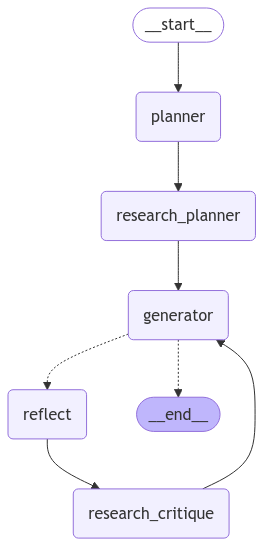

In [175]:
#Plotting the Graph
graph=builder.compile()
Image(graph.get_graph().draw_mermaid_png())

In [176]:
# Define a function to encapsulate the graph creation and execution
def run_graph(task, max_revisions):
    with SqliteSaver.from_conn_string(":memory:") as memory:
        graph = builder.compile(checkpointer=memory)
        thread = {"configurable": {"thread_id": 1}}
        for s in graph.stream(
            {"task": task, "max_revisions": max_revisions, "revision_number": 1}, thread
        ):
            print(s)



In [178]:
# Call the function with your desired task and max_revisions
run_graph("Tell me about the fishes found in India", 4)

{'planner': {'plan': "<think>\nOkay, so I need to write a high-level outline about the fishes found in India. Hmm, where do I even start? I guess I should first think about what the user is asking for. They want an outline, so I should structure it in a way that covers all the important aspects of the topic.\n\nFirst, I remember that India has both freshwater and marine ecosystems. So maybe I should divide the outline into those two main categories. That makes sense because the types of fish in each habitat are quite different. \n\nUnder freshwater, I know that rivers, lakes, and wetlands are the main sources. The Ganges River comes to mind, and maybe the Brahmaputra. I think the Ganges has some specific fish like the Ganges River Dolphin, but wait, that's a dolphin, not a fish. Oh, maybe the Hilsa? I think Hilsa is found in rivers. Also, there are carp species like the Common Carp and Catla. Oh, and the Indian Major Carp, which includes Rohu, Catla, and Mrigal. I should include those.

AttributeError: 'HumanMessage' object has no attribute 'items'